<a href="https://colab.research.google.com/github/nupoorsagar/FruitClassifier-using-MobileNetV2/blob/main/basepaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os

zip_path = "/content/archive.zip"  # Update if needed
extract_path = "/content/fruits_dataset"

# Unzipping
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check extracted files
os.listdir(extract_path)


['images']

**RESIZING (256X256)**

In [ ]:
import os
from PIL import Image
import glob

# Define the path to images
dataset_path = "/content/fruits_dataset"

# Loop through each fruit folder
for fruit_folder in os.listdir(dataset_path):
    fruit_path = os.path.join(dataset_path, fruit_folder)

    if os.path.isdir(fruit_path):  # Ensure it's a folder
        for img_file in glob.glob(f"{fruit_path}/*.*"):  # Select only files
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filter image files
                try:
                    img = Image.open(img_file)
                    img = img.resize((256, 256))  # Resize to 256x256
                    img.save(img_file)  # Overwrite the image
                except Exception as e:
                    print(f"Error processing {img_file}: {e}")

print("✅ All images resized to 256x256 pixels successfully!")


✅ All images resized to 256x256 pixels successfully!


In [ ]:
import os
from PIL import Image
import random

dataset_path = "/content/fruits_dataset/images"
for fruit_folder in os.listdir(dataset_path):
    fruit_path = os.path.join(dataset_path, fruit_folder)

    if os.path.isdir(fruit_path):  # Ensure it's a folder
        images = [img for img in os.listdir(fruit_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if images:  # Check at least one image
            random_img = random.choice(images)  # Pick a random image
            img_path = os.path.join(fruit_path, random_img)

            img = Image.open(img_path)
            print(f"{fruit_folder}: {random_img} -> {img.size}")  # Print size of the image

grapes fruit: Image_31.jpg -> (256, 256)
cherry fruit: Image_39.jpg -> (256, 256)
orange fruit: Image_24.jpg -> (256, 256)
strawberry fruit: Image_17.jpg -> (256, 256)
kiwi fruit: Image_3.jpg -> (256, 256)
chickoo fruit: Image_33.jpg -> (256, 256)
mango fruit: Image_27.jpeg -> (256, 256)
apple fruit: Image_36.jpg -> (256, 256)
banana fruit: Image_16.jpg -> (256, 256)


**DATA AUGMENTATION**

4252 IMAGES , 32 BATCH SIZE , 133 BATCHES PER EPOCH

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, UnidentifiedImageError

# Define dataset paths
dataset_path = "/content/fruits_dataset/images"
augmented_path = "/content/fruits_dataset_augmented"

# Create augmented folder if not exists
os.makedirs(augmented_path, exist_ok=True)

# Define ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1.0 / 255,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode="nearest",
)

# Process each fruit category
for fruit_folder in os.listdir(dataset_path):
    fruit_path = os.path.join(dataset_path, fruit_folder)
    fruit_aug_path = os.path.join(augmented_path, fruit_folder)

    if os.path.isdir(fruit_path):
        os.makedirs(fruit_aug_path, exist_ok=True)

        for img_file in os.listdir(fruit_path):
            img_path = os.path.join(fruit_path, img_file)

            try:
                with Image.open(img_path) as img:
                    # ✅ Convert RGBA/Grayscale to RGB
                    img = img.convert("RGB")

                    img_array = np.array(img)
                    img_array = img_array.reshape((1,) + img_array.shape)

                    # Generate and save 5 augmented images per original
                    i = 0
                    for batch in datagen.flow(
                        img_array,
                        batch_size=1,
                        save_to_dir=fruit_aug_path,
                        save_prefix="aug",
                        save_format="jpg",  # ✅ Ensure all saved images are JPG
                    ):
                        i += 1
                        if i >= 5:
                            break

            except UnidentifiedImageError:
                print(f"❌ Skipping unreadable image: {img_path}")
            except Exception as e:
                print(f"⚠️ Error processing {img_path}: {e}")

print("✅ Data Augmentation Complete! Check", augmented_path)


❌ Skipping unreadable image: /content/fruits_dataset/images/orange fruit/Image_27.jpg
❌ Skipping unreadable image: /content/fruits_dataset/images/kiwi fruit/Image_35.jpg
✅ Data Augmentation Complete! Check /content/fruits_dataset_augmented


**MODEL BUILDING (10 LAYERS)**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the augmented dataset
datagen = ImageDataGenerator(rescale=1.0/255)

train_data = datagen.flow_from_directory(
    'fruits_dataset_augmented',  # Ensure the correct path
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical'  # Multi-class classification
)

# Get number of classes dynamically
num_classes = len(train_data.class_indices)
print(f"Detected {num_classes} classes: {train_data.class_indices}")

# Define the CNN model
model = Sequential([
    # Explicit Input Layer
    Input(shape=(32, 32, 3)),

    # Layer 1 & 2: Conv2D (32 filters, kernel size 3x3, ReLU)
    Conv2D(32, (3,3), activation='relu', padding='same'),
    Conv2D(32, (3,3), activation='relu', padding='same'),

    # Layer 3: MaxPooling2D (pool size 2x2, stride 2)
    MaxPooling2D(pool_size=(2,2), strides=2),

    # Layer 4: Conv2D (64 filters, kernel size 3x3, ReLU)
    Conv2D(64, (3,3), activation='relu', padding='same'),

    # Layer 5: MaxPooling2D (pool size 2x2, stride 2)
    MaxPooling2D(pool_size=(2,2), strides=2),

    # Layer 6: BatchNormalization
    BatchNormalization(),

    # Layer 7: Conv2D (128 filters, kernel size 3x3, ReLU)
    Conv2D(128, (3,3), activation='relu', padding='same'),

    # Layer 8: MaxPooling2D (pool size 2x2, stride 2)
    MaxPooling2D(pool_size=(2,2), strides=2),

    # Layer 9: Flatten → Dense (256 units, ReLU, Dropout 50%)
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    # Layer 10: Output Dense (9 classes, Softmax activation)
    Dense(num_classes, activation='softmax')
])

# Set Adam optimizer with learning rate 0.0001
optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

# Train the model
history = model.fit(
    train_data,
    epochs=30  # Adjust based on training performance
)

# Save model
model.save("fruit_classifier_augmented.h5")
print("Model training completed and saved!")


Found 4252 images belonging to 9 classes.
Detected 9 classes: {'apple fruit': 0, 'banana fruit': 1, 'cherry fruit': 2, 'chickoo fruit': 3, 'grapes fruit': 4, 'kiwi fruit': 5, 'mango fruit': 6, 'orange fruit': 7, 'strawberry fruit': 8}


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 629,609 (2.40 MB)

 Trainable params: 629,481 (2.40 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 168ms/step - accuracy: 0.2933 - loss: 1.9493
Epoch 2/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 22s 167ms/step - accuracy: 0.5520 - loss: 1.2645
Epoch 3/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.6407 - loss: 1.0511
Epoch 4/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 23s 172ms/step - accuracy: 0.7053 - loss: 0.8763
Epoch 5/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 23s 170ms/step - accuracy: 0.7148 - loss: 0.8046
Epoch 6/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step - accuracy: 0.7635 - loss: 0.7079
Epoch 7/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 23s 170ms/step - accuracy: 0.7698 - loss: 0.6569
Epoch 8/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 23s 171ms/step - accuracy: 0.7997 - loss: 0.5747
Epoch 9/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 42s 178ms/step - accuracy: 0.8108 - loss: 0.5454
Epoch 10/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.8474 - loss: 0.4589
Epoch 11/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 22s 168ms/step - accuracy: 0.8610 - loss: 0.4145
Epoch 12/30
133/133

Model training completed and saved!


98.22 ACCURACY AND 0.0703 LOSS AFTER 30 EPOCHS

Found 45 images belonging to 9 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step
Classification Report:

              precision    recall  f1-score   support

       apple       0.67      0.80      0.73         5
      banana       1.00      0.20      0.33         5
      cherry       1.00      0.80      0.89         5
     chickoo       0.33      1.00      0.50         5
      grapes       0.83      1.00      0.91         5
        kiwi       1.00      0.20      0.33         5
       mango       0.75      0.60      0.67         5
      orange       1.00      1.00      1.00         5
  strawberry       1.00      0.60      0.75         5

    accuracy                           0.69        45
   macro avg       0.84      0.69      0.68        45
weighted avg       0.84      0.69      0.68        45



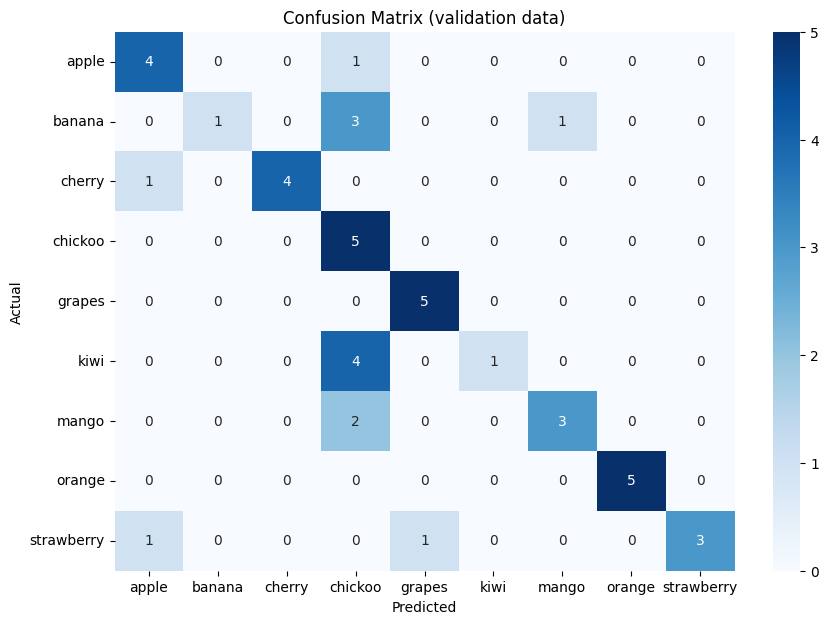

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

model = load_model("/content/fruit_classifier_augmented.h5")

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0/255)
train_data = datagen.flow_from_directory(
    '/content/validation_images',
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
pred_probs = model.predict(train_data)
y_pred = np.argmax(pred_probs, axis=1)
y_true = train_data.classes
class_labels = list(train_data.class_indices.keys())
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (validation data)')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation and generator
train_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    '/content/fruits_dataset_augmented',
    target_size=(32, 32),
    batch_size=32,  # This is the batch size
    class_mode='categorical'
)

print(f"Batch Size: {train_data.batch_size}")


Found 4252 images belonging to 9 classes.
Batch Size: 32


In [ ]:
num_batches = len(train_data)
print(f"Total Batches per Epoch: {num_batches}")

Total Batches per Epoch: 133


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load a single test image
img_path = "/content/Screenshot 2025-04-05 at 6.52.09 PM.png"
img = image.load_img(img_path, target_size=(32, 32))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict the class
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)  # Get highest probability class

# Print results
class_labels = list(train_data.class_indices.keys())  # Get class labels
print(f"Predicted Class: {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Predicted Class: kiwi


In [ ]:
import zipfile
import os

zip_path = "/content/validation_5_each.zip"  # Update if needed
extract_path = "/content/validation_images"

# Unzipping
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check extracted files
os.listdir(extract_path)

['apple',
 'cherry',
 'banana',
 'grapes',
 'mango',
 'chickoo',
 'strawberry',
 'kiwi',
 'orange']

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load saved model
model = load_model('/content/fruit_classifier_augmented.h5')

# Define validation data directory
validation_dir = "/content/validation_images"

# Preprocess images (resize and normalize)
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
# Evaluate model on validation data
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Found 45 images belonging to 9 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6884 - loss: 1.3758 
Validation Accuracy: 68.89%
